In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from scipy.signal import convolve2d
import argparse
import sys

In [32]:
def load_and_process_image(image_path, target_size=(100, 100), threshold=128):
    """
    Converts an image to a binary grid for Game of Life.
    """
    try:
        # Open image, convert to grayscale
        img = Image.open(image_path).convert('L')
        
        # Resize image to fit the grid (maintain aspect ratio logic can be added here)
        # For GoL, a square or fixed grid is usually easier to visualize
        img = img.resize(target_size, Image.Resampling.NEAREST)
        
        # Convert to numpy array
        img_data = np.array(img)
        
        # Binarize: Cells > threshold are ALIVE (1), others DEAD (0)
        # We flip the logic often because images usually have white backgrounds.
        # Here: Darker pixels = Alive, Lighter = Dead
        grid = (img_data < threshold).astype(int)
        
        return grid
    except Exception as e:
        print(f"Error loading image: {e}")
        sys.exit(1)

def update_grid(grid):
    """
    Computes the next generation of the Game of Life using convolution.
    """
    # Kernel to sum neighbors
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])
    
    # Count neighbors (boundary='wrap' allows for toroidal/wrapping world)
    neighbor_count = convolve2d(grid, kernel, mode='same', boundary='wrap')
    
    # Apply Conway's Rules:
    # 1. Survival: Alive (1) and 2 or 3 neighbors -> 1
    # 2. Birth: Dead (0) and 3 neighbors -> 1
    # 3. Death: All other cases -> 0
    
    next_grid = np.zeros_like(grid)
    
    # Pythonic implementation of rules using boolean masks
    alive_condition = (grid == 1) & ((neighbor_count == 2) | (neighbor_count == 3))
    birth_condition = (grid == 0) & (neighbor_count == 3)
    
    next_grid[alive_condition | birth_condition] = 1
    
    return next_grid

def run_simulation(image_path,n,m,k,l):
    #n,m are grid size
    #k is gray scale threshold
    #l is length
    """
    Sets up the animation loop.
    """
    # Configuration
    GRID_SIZE = (n,m) # (Width, Height)
    THRESHOLD = k        # Adjust based on image brightness (0-255)
    
    # Load initial state
    grid = load_and_process_image(image_path, GRID_SIZE, THRESHOLD)
    
    # Setup Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')
    
    # Create image object
    img_plot = ax.imshow(grid, interpolation='nearest', cmap='binary')
    ax.set_title("Conway's Game of Life: Generation 0")

    def animate(frame):
        nonlocal grid
        # Update data
        grid = update_grid(grid)
        img_plot.set_data(grid)
        ax.set_title(f"Conway's Game of Life: Generation {frame}")
        return [img_plot]

    # Create Animation
    # interval=100 means 100ms between frames
    ani = animation.FuncAnimation(fig, animate, interval=150, blit=False, save_count = l)
    ani.save("test.gif")

    plt.show()

#if __name__ == "__main__":
    # Quick check for command line args
#    if len(sys.argv) < 2:
#        print("Usage: python img_to_life.py <path_to_image>")
#        print("Example: python img_to_life.py logo.png")
#    else:
#        run_simulation(sys.argv[1])


MovieWriter ffmpeg unavailable; using Pillow instead.

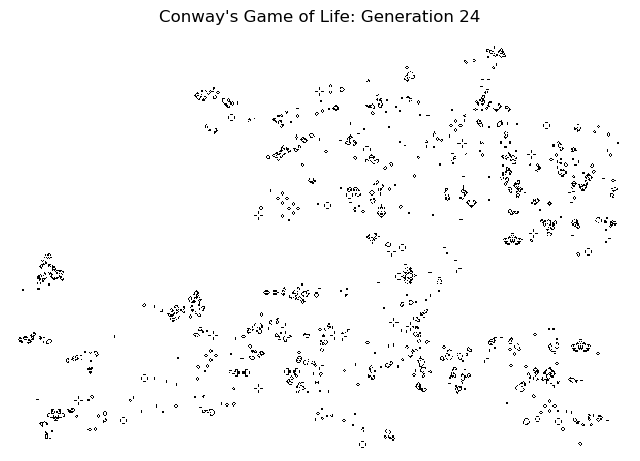

In [33]:
run_simulation('/Users/connorlockhart/Documents/GitHub/game_of_life_images/test_images/plumblossom.jpg',600,408,100,25)